# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является улучшением Baseline к соревнованию по определению стоимости авто*   

## За основу был взят baseline по определению стоимости авто
Далее мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе XGBRegressor
* Сделаем третию модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно с попыткой леммитизации и очистки текста
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование всех предыдущих моделей (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3
!pip install albumentations -q
!pip install pymorphy2

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 55 kB 801 kB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 14.6 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import random
import math
import numpy as np
import pandas as pd
import datetime
import os
import sys
import PIL
import cv2
import re
import json
import pickle

import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from pymorphy2 import MorphAnalyzer

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
from itertools import combinations, product, chain

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_hub as hub
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def print_mape_root(y_true, y_pred):
    mape = np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))
    print("MAPE:",mape)

In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

LR          = 0.3
VAL_SIZE    = 0.15  

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [6]:
DATA_DIR = '/input/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [8]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# EDA

Проведем анализ данных при необходимости сразу вносим коррективы.

In [9]:
train.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

In [10]:
test.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  0
Владение                1092
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

видно, что есть единичные признаки, необходимо будет удалить строку с пустым признаком 'Владельцы'

### bodyType - кат. признак

In [11]:
train['bodyType'].value_counts()

седан                   2843
внедорожник 5 дв.       2315
купе                     427
хэтчбек 5 дв.            296
лифтбек                  245
универсал 5 дв.          153
минивэн                  146
купе-хардтоп              91
родстер                   60
кабриолет                 44
хэтчбек 3 дв.             41
компактвэн                 8
лимузин                    5
внедорожник 3 дв.          3
пикап двойная кабина       2
внедорожник открытый       2
седан 2 дв.                1
Name: bodyType, dtype: int64

In [12]:
test['bodyType'].value_counts()

седан                   698
внедорожник 5 дв.       581
купе                    116
хэтчбек 5 дв.            68
лифтбек                  54
универсал 5 дв.          43
минивэн                  32
родстер                  28
купе-хардтоп             20
хэтчбек 3 дв.            16
кабриолет                10
внедорожник открытый      2
внедорожник 3 дв.         2
пикап двойная кабина      1
Name: bodyType, dtype: int64

На тесте отсутствуют: 1) седан 2 дв. 2) лимузин 3) компактвэн 

### brand - кат. признак

In [13]:
train['brand'].value_counts()

BMW         2805
MERCEDES    2294
AUDI        1583
Name: brand, dtype: int64

In [14]:
test['brand'].value_counts()

BMW         730
MERCEDES    552
AUDI        389
Name: brand, dtype: int64

### color - кат. признак

In [15]:
train['color'].value_counts()

чёрный         2805
белый          1263
серый           733
синий           685
серебристый     341
коричневый      307
красный         203
бежевый          76
голубой          72
зелёный          70
фиолетовый       37
пурпурный        30
оранжевый        22
золотистый       21
жёлтый           16
розовый           1
Name: color, dtype: int64

In [16]:
test['color'].value_counts()

чёрный         663
белый          344
серый          192
синий          178
серебристый     79
коричневый      79
красный         63
голубой         19
зелёный         16
фиолетовый       9
бежевый          9
пурпурный        8
оранжевый        8
золотистый       3
жёлтый           1
Name: color, dtype: int64

На тесте отсутствует розовый авто

### description - plain text

In [17]:
train['description'].head()

0    Авто на бодром ходу.  Все работает отлично.  П...
1    Продажа от собственника, второй владелец, ПТС ...
2    Внимание! Только для клиентов AVILON Автомобил...
3    В комплекте зимние колёса. 27.07.2020 Замена п...
4    Отличный авто, 2011 года выпуска, кроме передн...
Name: description, dtype: object

In [18]:
test['description'].head()

0    Всем привет!\n\nПродам эксклюзивный проект 124...
1    Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2    Машина тут продаётся не в первый раз, НО! Толь...
3    Автомобиль в отличном состоянии, весь в родной...
4    Немка! с бесключивым доступом и камерой заднег...
Name: description, dtype: object

In [19]:
test['description'][0]

'Всем привет!\n\nПродам эксклюзивный проект 124 универсал 300TE-24 SportLine\n\nМодель 124.091 300 TE-24\nДвигатель 104.980\nТрансмиссия 722.359\nЦвет кузова 040 (черный)\nОтделка салона 271 (Кожа черная / "антрацит")\n\nОпции:\n211 Автоматическая блокировка дифференциала (ASD)\n240 Индикатор внешней температуры\n244 Спортивные сиденья спереди\n281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП\n291 Подушка безопасности для водителя и переднего пассажира\n300 Дополнительный бардачок в вещевом отсеке спереди\n412 Люк с электроприводом и устройством подъёма\n420 Автоматическая коробка передач, напольное исполнение\n440 Темпомат (круиз-контроль)\n538 Автоматическая антенна\n541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)\n570 Складной подлокотник спереди\n586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей\n598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)\n650 Спорт

[(' ', 255), ('е', 175), ('о', 143), ('а', 142), ('и', 123), ('н', 110), ('р', 91), ('с', 85), ('к', 85), ('т', 83)]


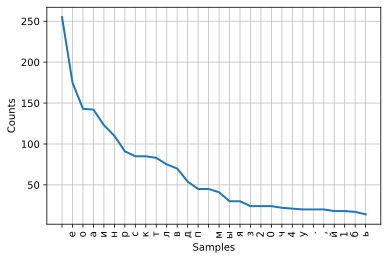

In [20]:
fdist = FreqDist(test['description'][0])
print(fdist.most_common(10))
fdist.plot(30,cumulative=False)

Часто встречающие буквы теперь нам известы, давайте посмотрим на часто встречающиеся слова.

[(',', 20), ('.', 17), ('(', 10), (')', 10), ('и', 10), ('с', 7), ('для', 4), ('передних', 4), ('Автоматическая', 3), ('спереди', 3)]


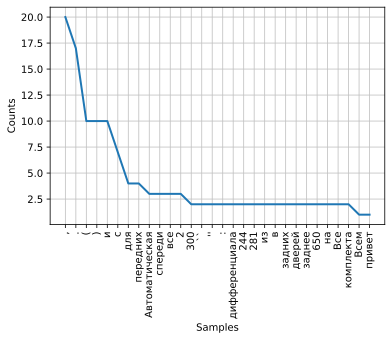

In [21]:
words = nltk.tokenize.word_tokenize(test['description'][0])
fdist = FreqDist(words)
print(fdist.most_common(10))
fdist.plot(30,cumulative=False)

Очевидно, что текст нам необходимо будет почистить от знаков препинания и различных союзов

In [22]:
need_repair = train['description'].apply(lambda x: 'требует ремонта' in x.lower())
need_repair.value_counts()

False    6583
True       99
Name: description, dtype: int64

In [23]:
need_repair = test['description'].apply(lambda x: 'требует ремонта' in x.lower())
need_repair.value_counts()

False    1639
True       32
Name: description, dtype: int64

In [24]:
feature_cruise = train['description'].apply(lambda x: 1 if 'круиз-контроль' in x else 0)
feature_cruise.value_counts()

0    6529
1     153
Name: description, dtype: int64

In [25]:
feature_cruise = test['description'].apply(lambda x: 1 if 'круиз-контроль' in x else 0)
feature_cruise.value_counts()

0    1631
1      40
Name: description, dtype: int64

Имеет место добавить пару признаков из описания

### engineDisplacement - числовой признак

In [26]:
train['engineDisplacement']

0       3.0 LTR
1       2.8 LTR
2       3.5 LTR
3       2.0 LTR
4       1.8 LTR
         ...   
6677    2.0 LTR
6678    2.0 LTR
6679    2.0 LTR
6680    3.0 LTR
6681    6.0 LTR
Name: engineDisplacement, Length: 6682, dtype: object

In [27]:
train['engineDisplacement'].value_counts()

2.0 LTR          1929
3.0 LTR          1862
1.8 LTR           329
1.6 LTR           327
4.4 LTR           260
5.5 LTR           227
3.5 LTR           208
2.5 LTR           203
2.1 LTR           181
4.0 LTR           121
4.7 LTR           109
2.8 LTR            89
1.4 LTR            82
4.2 LTR            80
1.5 LTR            61
5.0 LTR            60
3.2 LTR            49
2.2 LTR            44
2.9 LTR            43
4.8 LTR            41
3.1 LTR            39
2.4 LTR            38
6.2 LTR            31
1.3 LTR            30
6.0 LTR            30
5.4 LTR            27
1.2 LTR            26
2.7 LTR            22
4.1 LTR            19
3.6 LTR            18
3.7 LTR            11
1.7 LTR            11
5.2 LTR            10
5.9 LTR            10
2.6 LTR             7
undefined LTR       5
2.3 LTR             5
4.6 LTR             5
0.7 LTR             5
6.6 LTR             4
1.9 LTR             4
3.4 LTR             4
4.3 LTR             3
5.6 LTR             3
6.3 LTR             3
5.8 LTR   

In [28]:
test['engineDisplacement'].value_counts()

2.0 LTR          501
3.0 LTR          487
1.6 LTR           83
1.8 LTR           82
4.4 LTR           69
2.5 LTR           45
3.5 LTR           42
5.5 LTR           41
2.1 LTR           40
4.0 LTR           32
4.7 LTR           28
1.4 LTR           24
4.2 LTR           23
2.8 LTR           17
4.8 LTR           16
5.0 LTR           14
2.2 LTR           14
1.5 LTR           12
3.2 LTR           11
6.2 LTR            9
2.3 LTR            9
2.9 LTR            7
1.2 LTR            7
6.0 LTR            7
5.4 LTR            6
2.4 LTR            6
3.1 LTR            5
3.6 LTR            5
1.7 LTR            4
4.1 LTR            4
3.7 LTR            3
5.2 LTR            3
1.3 LTR            2
5.8 LTR            2
2.7 LTR            2
2.6 LTR            2
1.9 LTR            1
6.6 LTR            1
5.9 LTR            1
3.8 LTR            1
undefined LTR      1
0.7 LTR            1
4.3 LTR            1
Name: engineDisplacement, dtype: int64

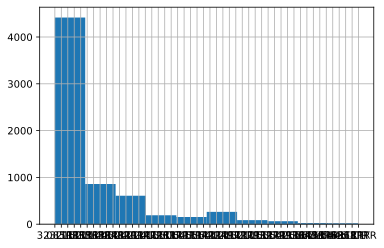

In [29]:
train['engineDisplacement'].hist()

Есть авто с undefined LTR скорее всего это электромобили

In [30]:
train[train['engineDisplacement'] == 'undefined LTR'][['brand','fuelType']]

,brand,fuelType
2296,BMW,электро
3725,BMW,электро
3726,BMW,электро
5862,BMW,электро
6283,BMW,электро


Так и есть, соответственно объём двигателя необходимо поставить 0 у таких авто

### enginePower - числовой признак

In [31]:
train['enginePower'].value_counts()

184 N12    602
249 N12    531
190 N12    343
306 N12    282
245 N12    274
          ... 
223 N12      1
457 N12      1
329 N12      1
580 N12      1
430 N12      1
Name: enginePower, Length: 146, dtype: int64

In [32]:
test['enginePower'].value_counts()

184 N12    157
249 N12    124
245 N12     81
190 N12     77
211 N12     66
          ... 
626 N12      1
445 N12      1
571 N12      1
109 N12      1
133 N12      1
Name: enginePower, Length: 120, dtype: int64

### fuelType - кат. признак

In [33]:
train['fuelType'].value_counts()

бензин     4804
дизель     1861
гибрид       12
электро       5
Name: fuelType, dtype: int64

In [34]:
test['fuelType'].value_counts()

бензин     1214
дизель      454
гибрид        2
электро       1
Name: fuelType, dtype: int64

### mileage - числовой признак

In [35]:
train['mileage'].value_counts()

150000    69
120000    64
180000    60
130000    57
140000    51
          ..
44107      1
203849     1
201800     1
9286       1
90134      1
Name: mileage, Length: 2900, dtype: int64

In [36]:
test['mileage'].value_counts()

180000    17
120000    15
85000     13
135000    13
200000    13
          ..
103314     1
183993     1
1023       1
89904      1
1          1
Name: mileage, Length: 935, dtype: int64

### modelDate - числовой признак

In [37]:
train['modelDate'].value_counts()

2011    651
2013    582
2015    536
2014    527
2009    525
2008    449
2012    445
2007    423
2016    377
2010    332
2006    282
2005    267
2017    240
2004    203
2018    196
2003    112
2002    111
2001     61
2000     61
2019     58
1999     45
1998     43
1990     40
1994     23
1995     17
1997     13
1992     13
1996     11
1987     10
1982      5
1985      4
1984      4
1979      3
1991      3
1977      2
1981      2
1988      2
1989      1
1986      1
1975      1
1976      1
Name: modelDate, dtype: int64

In [38]:
test['modelDate'].value_counts()

2011    179
2013    157
2014    140
2009    130
2015    120
2007    119
2008    113
2012    103
2016     90
2010     75
2006     63
2017     58
2005     54
2004     39
2018     38
2003     34
2002     24
2019     24
2000     19
2001     15
1999     13
1998     13
1995      8
1994      8
1990      8
1984      6
1996      4
1989      4
1985      3
1997      3
1975      1
1979      1
1991      1
1987      1
1992      1
1993      1
1971      1
Name: modelDate, dtype: int64

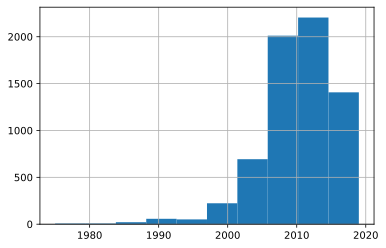

In [39]:
train['modelDate'].hist()

Можно будет добавить признакнак как разница текущего года и дата модели

### model_info - кат. признак

In [40]:
train['model_info'].value_counts()

5ER               611
3ER               466
E_KLASSE          410
X5                397
A6                358
                 ... 
SLR_KLASSE          1
100                 1
SLC_KLASSE_AMG      1
X3_M                1
None                1
Name: model_info, Length: 118, dtype: int64

In [41]:
test['model_info'].value_counts()

5ER              165
3ER              112
X5               104
E_KLASSE          80
A6                75
                ... 
M2                 1
X2                 1
CL_KLASSE_AMG      1
M4                 1
TTS                1
Name: model_info, Length: 101, dtype: int64

### name - кат. признак

In [42]:
train['name'].value_counts()

200 2.0 AT (184 л.с.)         121
35i 3.0 AT (306 л.с.) 4WD     116
2.0 AMT (211 л.с.) 4WD        113
30d 3.0d AT (249 л.с.) 4WD     87
400 3.0 AT (333 л.с.) 4WD      76
                             ... 
728Li 2.8 AT (193 л.с.)         1
2.8 CVT (210 л.с.)              1
3.8 MT (340 л.с.)               1
740Li 4.4 AT (286 л.с.)         1
2.0 CVT (220 л.с.)              1
Name: name, Length: 900, dtype: int64

In [43]:
test['name'].value_counts()

35i 3.0 AT (306 л.с.) 4WD              35
2.0 AMT (211 л.с.) 4WD                 32
30d 3.0d AT (249 л.с.) 4WD             22
520i 2.0 AT (184 л.с.)                 21
400 3.0 AT (333 л.с.) 4WD              21
                                       ..
740d xDrive 3.0d AT (320 л.с.) 4WD      1
320d 2.0d AT (163 л.с.)                 1
350 3.0d AT (231 л.с.)                  1
2.7 AT (250 л.с.) 4WD                   1
M550d xDrive 3.0d AT (400 л.с.) 4WD     1
Name: name, Length: 536, dtype: int64

Данный признак комбинированный, поэтому от него можно вообще избавиться

### numberOfDoors - кат. признак

In [44]:
train['numberOfDoors'].value_counts()

5    3090
4    2923
2     627
3      42
Name: numberOfDoors, dtype: int64

In [45]:
test['numberOfDoors'].value_counts()

5    764
4    713
2    175
3     19
Name: numberOfDoors, dtype: int64

### productionDate - числовой признак

In [46]:
train['productionDate'].value_counts()

2013    632
2011    559
2014    550
2012    541
2016    483
2015    483
2017    443
2008    421
2018    415
2010    376
2019    363
2009    281
2007    269
2005    146
2006    145
2004    118
2003     87
2020     82
2002     62
2001     54
2000     34
1999     32
1998     18
1997     14
1995     12
1994     11
1996     10
1993      9
1992      8
1990      6
1988      4
1986      3
1985      3
1983      2
1982      2
1984      2
1989      1
1987      1
Name: productionDate, dtype: int64

In [47]:
test['productionDate'].value_counts()

2013    151
2014    143
2011    143
2012    139
2017    119
2016    117
2015    116
2018    114
2010     92
2008     89
2019     86
2007     74
2009     64
2004     37
2006     37
2005     24
2001     19
2020     18
2002     16
1999     13
2003     13
2000      9
1997      7
1998      6
1994      4
1992      4
1990      4
1993      3
1996      2
1995      2
1991      2
1986      1
1985      1
1984      1
1982      1
Name: productionDate, dtype: int64

Можно будет добавить признак возраст авто, как разница текущего года и годом производства авто

### sell_id - числовой признак

In [48]:
train['sell_id'].value_counts()

1099612970    1
1100203538    1
1099489714    1
1093125466    1
1099999470    1
             ..
1099713260    1
1099983600    1
1099413790    1
1090587380    1
1097908224    1
Name: sell_id, Length: 6682, dtype: int64

In [49]:
test['sell_id'].value_counts()

1100170466    1
1099542002    1
1100113274    1
1088488828    1
1099679102    1
             ..
1100023524    1
1100233444    1
1091995140    1
1099721446    1
1099882496    1
Name: sell_id, Length: 1671, dtype: int64

Похоже это уникальный идентификатор, его смело потом удалим

### vehicleConfiguration - кат. признак

In [50]:
train['vehicleConfiguration'].value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0    1030
SEDAN AUTOMATIC 2.0               746
SEDAN AUTOMATIC 3.0               500
ALLROAD_5_DOORS AUTOMATIC 2.0     413
ALLROAD_5_DOORS ROBOT 2.0         176
                                 ... 
WAGON_5_DOORS MECHANICAL 3.0        1
CABRIO MECHANICAL 4.2               1
COUPE_HARDTOP AUTOMATIC 2.6         1
MINIVAN AUTOMATIC 2.8               1
WAGON_5_DOORS AUTOMATIC 5.5         1
Name: vehicleConfiguration, Length: 288, dtype: int64

In [51]:
test['vehicleConfiguration'].value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0     262
SEDAN AUTOMATIC 2.0               195
SEDAN AUTOMATIC 3.0               131
ALLROAD_5_DOORS AUTOMATIC 2.0     111
ALLROAD_5_DOORS ROBOT 2.0          50
                                 ... 
HATCHBACK_5_DOORS VARIATOR 2.0      1
WAGON_5_DOORS AUTOMATIC 2.1         1
SEDAN AUTOMATIC 2.3                 1
SEDAN AUTOMATIC 4.3                 1
HATCHBACK_5_DOORS ROBOT 2.0         1
Name: vehicleConfiguration, Length: 205, dtype: int64

Данный признак комбинированный, поэтому от него можно вообще избавиться

### vehicleTransmission - кат. признак

In [52]:
train['vehicleTransmission'].value_counts()

автоматическая      5261
роботизированная     959
вариатор             325
механическая         137
Name: vehicleTransmission, dtype: int64

In [53]:
test['vehicleTransmission'].value_counts()

автоматическая      1299
роботизированная     242
вариатор              81
механическая          49
Name: vehicleTransmission, dtype: int64

### Владельцы - кат. признак

In [54]:
train['Владельцы'].value_counts()

3 или более    2646
1 владелец     2029
2 владельца    2006
Name: Владельцы, dtype: int64

In [55]:
test['Владельцы'].value_counts()

3 или более    665
2 владельца    509
1 владелец     497
Name: Владельцы, dtype: int64

### Владение - числовой признак в тексте

In [56]:
train['Владение'].value_counts()

1 год и 8 месяцев     54
1 год и 2 месяца      53
1 год и 5 месяцев     46
9 месяцев             46
1 год                 46
                      ..
13 лет и 3 месяца      1
17 лет и 4 месяца      1
13 лет и 8 месяцев     1
17 лет и 5 месяцев     1
14 лет и 5 месяцев     1
Name: Владение, Length: 173, dtype: int64

In [57]:
test['Владение'].value_counts()

1 год и 2 месяца       14
8 месяцев              13
3 года                 13
1 год и 8 месяцев      13
2 года                 12
                       ..
19 лет                  1
10 лет и 7 месяцев      1
10 лет                  1
12 лет и 4 месяца       1
10 лет и 11 месяцев     1
Name: Владение, Length: 131, dtype: int64

### ПТС - кат. признак

In [58]:
train['ПТС'].value_counts()

Оригинал    5970
Дубликат     712
Name: ПТС, dtype: int64

In [59]:
test['ПТС'].value_counts()

Оригинал    1504
Дубликат     167
Name: ПТС, dtype: int64

### Привод - кат. признак

In [60]:
train['Привод'].value_counts()

полный      4189
задний      1790
передний     703
Name: Привод, dtype: int64

In [61]:
test['Привод'].value_counts()

полный      1029
задний       469
передний     173
Name: Привод, dtype: int64

### Руль - кат. признак

In [62]:
train['Руль'].value_counts()

Левый     6680
Правый       2
Name: Руль, dtype: int64

In [63]:
test['Руль'].value_counts()

Левый    1671
Name: Руль, dtype: int64

На тесте нет праворуких авто, значит из обучающей выборки можно удалить

В итоге по анализу видно, что необходимо

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [64]:
# split данных
data_train, data_test = train_test_split(train, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [65]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


Посмотрим, как выглядят распределения числовых признаков:

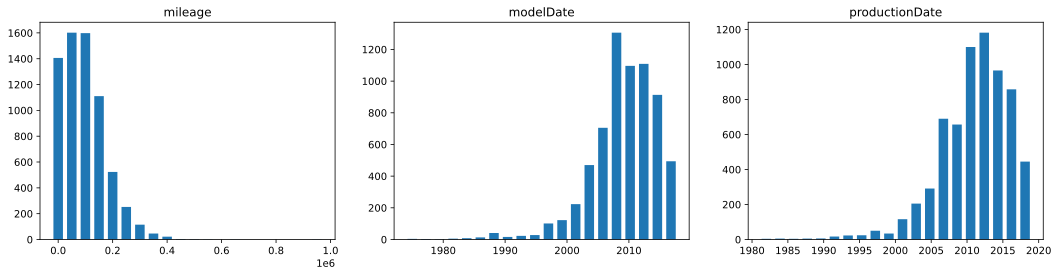

In [66]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

Вспомогательные функции по обработке данных

In [67]:
def conv_displacement(value):
    if value == 'undefined LTR':
        return 0.0000000001
    match = re.search('\d+\.\d+', value)
    return float(match[0]) if match else 0.

def conv_number(value):
    match = re.search('\d+', value)
    return int(match[0]) if match else 0

In [68]:
#используем все текстовые признаки как категориальные
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [69]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [70]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['sell_id'], axis = 1, inplace=True)   
    df_output = df_output.dropna(subset = ['Владельцы'], axis = 0)
    
    # ################### Numerical Features ############################################################## 
    # далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # ################### Clean #################################################### 
    # убираем лишние признаки 
    
    df_output = df_output[df_output['bodyType'] != 'компактвэн']
    df_output = df_output[df_output['bodyType'] != 'лимузин']
    df_output = df_output[df_output['bodyType'] != 'седан 2 дв.']
    df_output = df_output[df_output['Руль'] == 'Левый']
    df_output.drop(['name', 'vehicleConfiguration', 'Владение', 'Руль'], axis = 1, inplace=True)
    
     # тут ваш код не Encoding фитчей
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(conv_displacement)   
    df_output['enginePower'] = df_output['enginePower'].apply(conv_number)
    df_output['Владельцы'] = df_output['Владельцы'].apply(conv_number)
    
    # ################### Feature Engineering ####################################################
    # тут ваш код на генерацию новых фитчей    
    df_output['car_age'] = 2021 - df_output['productionDate']
    df_output['model_age'] = 2021 - df_output['modelDate']    
    #df_output['mileage_to_age'] = df_output['mileage'] / df_output['car_age']
    df_output['need_repair'] = df_output['description'].apply(lambda x: 1 if 'требует ремонта' in x.lower() else 0)
    df_output['feature_cruise'] = df_output['description'].apply(lambda x: 1 if 'круиз-контроль' in x else 0)
    
    numerical_features.append('car_age')
    numerical_features.append('model_age')   
    numerical_features.append('enginePower')
    numerical_features.append('engineDisplacement')  
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding:
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = np.log(df_output[column])
        df_output[column] = df_output[column].astype('float')
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
        
    df_output.drop(['description'], axis = 1, inplace=True)
    
    return df_output

In [71]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,car_age,model_age,need_repair,...,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
3473,0.943119,0.185277,0.837413,0.834995,0.817211,1,764000.0,0.567601,0.500000,0,...,0,1,0,1,0,0,1,0,1,0
2302,0.983725,0.891757,0.781699,0.793642,0.764868,1,1700000.0,0.628510,0.556641,0,...,0,0,0,1,0,0,1,0,0,1
7995,0.968351,0.482987,0.916385,0.669333,0.633785,1,800000.0,0.739185,0.682606,0,...,0,0,0,1,0,0,1,0,0,1
932,0.968351,0.604872,0.822416,0.814324,0.791046,0,0.0,0.599751,0.529610,0,...,0,1,0,1,0,0,1,0,0,1
5364,0.968351,0.614106,0.865055,0.752247,0.712474,1,1280000.0,0.678276,0.604531,0,...,0,0,0,0,1,1,0,0,0,1
5935,0.943119,0.281630,0.712705,0.979410,0.947839,1,1719000.0,0.299875,0.125965,0,...,0,0,1,0,0,0,1,1,0,0
1263,0.974539,0.614106,0.785442,0.814324,0.817211,0,0.0,0.567601,0.529610,0,...,0,0,1,0,0,0,1,1,0,0
2319,0.947847,0.339998,0.831493,0.834995,0.791046,1,685000.0,0.599751,0.500000,0,...,0,0,0,0,1,0,1,0,1,0
5884,0.968351,0.614106,0.833333,0.876308,0.843362,1,1950000.0,0.531153,0.430677,0,...,0,0,0,0,1,0,1,0,0,1
7261,0.952076,0.517979,0.767909,0.958810,0.947839,1,2999000.0,0.299875,0.215338,0,...,0,0,1,0,0,0,1,0,0,1


In [72]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8337 entries, 0 to 8351
Columns: 183 entries, engineDisplacement to Привод_2
dtypes: float64(8), int64(3), uint8(172)
memory usage: 2.1 MB


## Split data

In [73]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [74]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 182 entries, engineDisplacement to Привод_2
dtypes: float64(8), int64(2), uint8(172)
memory usage: 424.3 KB


# Model 2: CatBoostRegressor

In [ ]:
def cross_val(X, y, params, cat_features, n_splits=3):
    metrics = []
    predict = None    
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    for train_ind, test_ind in skf.split(X, y):    
    
        X_train = X.iloc[train_ind]
        y_train = y[train_ind]
        
        X_test = X.iloc[test_ind]
        y_test = y[test_ind]
        
        print(params)
        
        model = CatBoostRegressor(iterations = params['iterations'],
                                  learning_rate = params['learning_rate'],
                                  depth = params['depth'],
                                  loss_function = params['loss_function'],
                                  l2_leaf_reg = params['l2_leaf_reg'],
                                  eval_metric = 'MAPE',
                                  random_seed = RANDOM_SEED,
                                  leaf_estimation_iterations = 10,
                                  task_type='GPU'
                                 )
        
        model.fit(X_train, y_train,
                  cat_features = cat_features,
                  eval_set = (X_test, y_test),
                  verbose_eval = 100
                 )
        
        y_pred = model.predict(X_test)
        m = mape(y_test, y_pred)
        metrics.append(m)
        
    return sum(metrics)/n_splits
    
def grid_search_cv(X, y, params, cat_features, n_splits=5):
    ps = {'mape':0,'params': []}
    
    predict = None
    
    for prms in tqdm(list(ParameterGrid(params)), ascii=True, desc='Params Tuning:'):
                          
        m = cross_val(X, y, prms, cat_features, n_splits=5)

        if m > ps['mape']:            
            ps['mape'] = m
            ps['params'] = prms
            
    print('MAPE: ' + str(ps['mape']))
    print('Params: ' + str(p['params']))
    
    return ps['params']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
params = {'iterations': [1500, 2000],          
          'learning_rate': [0.2, 0.25, 0.3, 0.004],
          'depth': [6, 7],
          'loss_function': ['RMSE', 'MAE'],
          'l2_leaf_reg': [3, 3.5]
         }
    
#best_params = grid_search_cv(X_train, y_train, params, [])
#Params: {'depth': 6, 'iterations': 1500, 'l2_leaf_reg': 3.5, 'learning_rate': 0.004, 'loss_function': 'MAE'}

In [ ]:
best_params = {'iterations': 8000,          
          'learning_rate': 0.004,
          'depth': 6,
          'loss_function': 'MAE',
          'l2_leaf_reg': 3.5
         }

In [ ]:
model = CatBoostRegressor(iterations = best_params['iterations'],
                          loss_function = best_params['loss_function'],
                          depth = best_params['depth'],
                          learning_rate = best_params['learning_rate'],
                          l2_leaf_reg = best_params['l2_leaf_reg'],
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric='MAE',
                          od_wait=500,
                          #task_type='GPU',
                          leaf_estimation_iterations = 10,
                         )
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          cat_features = [],
          verbose_eval=100,
          use_best_model=True,
          plot=True
         )

In [ ]:
# сохраним модель
pickle.dump(model, open('CatBoostRegressorModel.pkl', 'wb'))

In [ ]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape (min 11.16%): {(mape(y_test, test_predict_catboost))*100:0.2f}%")
print(f"TEST R2 (max 94.47%): {(r2_score(y_test, test_predict_catboost))*100:0.2f}%")

### Submission

In [ ]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [76]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,car_age,model_age,need_repair,feature_cruise,bodyType_0,...,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
8300,0.968351,0.778146,0.695044,0.938200,0.947839,0.299875,0.284662,0,0,0,...,0,0,1,0,0,0,1,0,0,1
7483,0.981857,0.571029,0.860228,0.440464,0.423370,0.855860,0.830771,0,0,0,...,0,0,0,0,1,1,0,1,0,0
6622,0.943119,0.299920,0.783162,0.876308,0.869501,0.489076,0.430677,0,0,0,...,0,1,0,0,1,0,1,0,1,0
6320,0.952076,0.510427,0.875476,0.814324,0.817211,0.567601,0.529610,0,0,0,...,0,0,0,0,1,0,1,0,0,1
7942,0.968351,0.614106,0.816271,0.752247,0.738678,0.654526,0.604531,0,0,0,...,0,0,0,1,0,0,1,0,0,1


## Simple Dense NN

In [77]:
model = Sequential()
r = regularizers.l1_l2(l1=0.000000001,l2=0.000000001)
model.add(L.Dense(512, input_dim=X_train.shape[1], kernel_regularizer=r, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, kernel_regularizer=r, activation="relu"))
model.add(L.Dropout(0.25))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
#model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor='val_MAPE', verbose=0, mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=512,                    
                    epochs=500,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=2,
                   )

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')

In [ ]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape (min 13.19%): {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")
print(f"TEST R2 (max 81.05%): {(r2_score(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 3.2: XGBRegressor

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBRegressor(max_depth=7, seed=RANDOM_SEED)
his = model.fit(X_train, y_train)
test_predict_xgbReg = model.predict(X_test)

In [ ]:
# сохраним модель
pickle.dump(model, open('XGBRegressor.pkl', 'wb'))

In [ ]:
print(f"TEST mape (min 13.27%): {(mape(y_test, test_predict_xgbReg))*100:0.2f}%")
print(f"TEST R2 (max 90.95%): {(r2_score(y_test, test_predict_xgbReg))*100:0.2f}%")

In [ ]:
sub_predict_xgbReg = model.predict(X_sub)
sample_submission['price'] = sub_predict_xgbReg
sample_submission.to_csv('nn12_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [78]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [79]:
nlp_df = data.copy()

In [80]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

данные у нас и так достаточно чистые, однако мне кажется если убрать лишние символы, то мы должны улучшить качество предсказания
будем использовать готовый словарь stopwords.
Так же расщирем данный словарь словами, которые не несут никакой смысловой нагрузки. Данные слова были выявлены как часто встречающиеся по разным описаниям, просмотрел порядка 20 описаний

In [82]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def lemmatize(s):    
    tokens = []
    for token in s.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

def clean_stopwords_shortwords(s):
    stopwords_list = stopwords.words('russian')
    stopwords_list.extend(['всем', 'привет', 'любимый', 'что', 'весь', 'продам', 'продаю', 'продается', 'месте', 
                          'сборка','вообще','на','фото','машина','сути','факту','авто','ооо','выгода','год',
                          'отрываю','сердца','красавца','поэтому','решил','таких','свои','хватает','связи',
                          'года','цвет','лет','организация','ждут','автомобиль','это','своего','своих'])
    words = s.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words)     

def preprocess_sentence(s):
    s = unicode_to_ascii(s.lower().strip())
    s = s.lower().strip()
    s = re.sub(r"[#$&?.!,¿'()*+,./:;<=>?@[\]^_`{|}~—\"\-]", r" ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = re.sub(r"[^а-яА-Я]+", " ", s)
    s = clean_stopwords_shortwords(s)
    s = re.sub(r'@\w+', '', s)
    return s

In [84]:
%%time
nlp_df['description'] = nlp_df.description.map(preprocess_sentence)

CPU times: user 6.63 s, sys: 164 ms, total: 6.79 s
Wall time: 6.8 s


In [85]:
%%time
morph = MorphAnalyzer()
nlp_df['description'] = nlp_df.apply(lambda nlp_df: lemmatize(nlp_df.description), axis=1)

CPU times: user 2min 36s, sys: 191 ms, total: 2min 36s
Wall time: 2min 36s


In [86]:
t = nlp_df.description[5354]
print(t)
words = nltk.tokenize.word_tokenize(t)
fdist = FreqDist(words)
fdist.most_common(15)

самый полный комплектация автопарковка спортрежим система удержание полоса чтение дорожный знак фирменный адаптивный круиз контроль мерседес сидение подогрев вентиляцией боковой электродверь своевременный обслуживание проиден деньга жалеть купить кредит непрокуренный салон участвовать дтп причина продажа покупка новый сервисный книжка тыс поменять тормозной диск ролик ремень заменить подрулевой переключатель тыс заменить компрессор радиатор кондиционер заднии среднии контур заменить качественный шланг промыть обслужить весь система климат контроль диск комплект резина диск зима лето ухоженный гаражный хранение рождение фактически второй хозяин городской использоваться транспортировка детея сад школа кружка тюнига передний задний бампер оригинальный заднии бампер комплект установить решётка оригинальный комплект потолочный монитор установить медиацентр самый лучшие медиацентр сегодняшние день возможность просмотр онлаин медиатечь видео любой формат блокировка движение оба экран сделать 

[('заменить', 4),
 ('дтп', 3),
 ('диск', 3),
 ('комплект', 3),
 ('установить', 3),
 ('самый', 2),
 ('полный', 2),
 ('система', 2),
 ('контроль', 2),
 ('салон', 2),
 ('покупка', 2),
 ('тыс', 2),
 ('заднии', 2),
 ('хозяин', 2),
 ('бампер', 2)]

In [87]:
# split данных
text_train = nlp_df.description.iloc[X_train.index]
text_test = nlp_df.description.iloc[X_test.index]
text_sub = nlp_df.description.iloc[X_sub.index]

### Tokenizer

In [88]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(nlp_df.description)

CPU times: user 955 ms, sys: 3 ms, total: 957 ms
Wall time: 957 ms


In [89]:
len(tokenize.word_index)

14707

In [90]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5666, 256) (1000, 256) (1671, 256)
CPU times: user 1.25 s, sys: 5.98 ms, total: 1.25 s
Wall time: 1.26 s


In [91]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

первыя международный официальный гипермаркет автомобилей пробег официальный дилер уникальный условие покупка автомобиль пробег обмен ваш покупка кредит одобрение течение час два документ выгодный условие выкуп ваш автомобиль получение сумма касса течение час полностью проверить технической кузовной часть критический недостаток выявить успешно проиден криминалистический проверка гарантия юридической чистота эксклюзивный преимущество представить автомобиль оригинальный птс климат контроль подогрев передний сидение светодиодный фара комфортный доступ камера задний вид полный комплект ключей документ особый условие представленный покупка кредит обмен комплектация антиблокировочный система антипробуксовочный система система курсовой устоичивость датчик давление шина подушка безопасность водитель подушка безопасность пассажир боковой передний задний подушка безопасность сигнализация иммобилаизер центральный замок бортовой компьютер круиз контроль парктроника переднии заднии камера задний вид

### RNN NLP with RuBERT

In [92]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8' 

tfhub_handle_encoder  = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

RuBERT использовать не увенчалось успехом, а жаль. Всё время выходили какие-то странные ошибки

In [93]:
#model_nlp_bert = Sequential()
#model_nlp_bert.add(L.Input(shape=(), dtype = tf.string, name = 'input_descr'))
#model_nlp_bert.add(hub.KerasLayer(tfhub_handle_preprocess, name = 'preprocessing_descr'))
#model_nlp_bert.add(hub.KerasLayer(tfhub_handle_encoder, trainable = True, name = 'BERT_encoder_descr'))
#model_nlp_bert.add(L.Dropout(0.5))
#model_nlp_bert.add(L.Flatten(0.5))
#model_nlp_bert.add(L.Dense(256, activation="relu"))
#model_nlp_bert.add(L.Dropout(0.5))

In [94]:
# без дополнительного слоя
class Attention(L.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape = (input_shape[-1], 1), initializer = "normal")
        self.b = self.add_weight(name="att_bias", shape = (input_shape[1], 1), initializer = "zeros")        
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis = -1)
        output = x * at
        return K.sum(output, axis = 1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(Attention, self).get_config()

In [95]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))

model_nlp.add(L.Conv1D(256, 7, activation='relu'))
model_nlp.add(L.MaxPooling1D(7))
model_nlp.add(L.Conv1D(128, 7, activation='relu'))
model_nlp.add(L.Dropout(0.2))
model_nlp.add(L.Conv1D(64, 7, activation='relu'))
model_nlp.add(L.Dropout(0.2))
    
model_nlp.add(L.Bidirectional(L.LSTM(256, dropout = 0.2, recurrent_dropout = 0.2, return_sequences=True)))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Bidirectional(L.LSTM(256, dropout = 0.2, recurrent_dropout = 0.2, return_sequences=True, go_backwards=True)))
#model_nlp.add(L.Flatten())
model_nlp.add(Attention())
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [96]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.25))

### Multiple Inputs NN

In [97]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [98]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     3765248     seq_description[0][0]            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 250, 256)     459008      embedding[0][0]                  
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 35, 256)      0           conv1d[0][0]                     
_______________________________________________________________________________________

### Fit

In [99]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [100]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor='val_MAPE', verbose=0, mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
def step_decay(epoch):
    return LR * math.pow(0.9, math.floor((1 + epoch) / 2))
lrScheduler = LearningRateScheduler(step_decay, verbose = 1)    
callbacks_list = [checkpoint, earlystop, lrScheduler]

In [101]:
def load_glove():
    # Open the word vector file, the first variable of each line is a word, and the next string of numbers is the corresponding word vector    
    embeddings_index = {}
    f = open(os.path.join(INPUT_PATH + 'glove-db/', 'glove.ruwiki.300d.txt'), encoding = 'utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs
    f.close()
    
    #Pre-trained words in the word vector do not appear in the 0 vector
    embedding_matrix = np.zeros((len(tokenize.word_index) + 1, len(embeddings_index['a'])))
    for word, i in tokenize.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector          
        
    return embedding_matrix, embeddings_index

#embedding_matrix, embeddings_index = load_glove()

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )


Epoch 00001: LearningRateScheduler reducing learning rate to 0.3.
Epoch 1/500
12/12 [==============================] - 7s 566ms/step - loss: 63.1931 - MAPE: 63.1931 - val_loss: 45.9227 - val_MAPE: 45.9227

Epoch 00002: LearningRateScheduler reducing learning rate to 0.27.
Epoch 2/500
12/12 [==============================] - 5s 455ms/step - loss: 40.4224 - MAPE: 40.4224 - val_loss: 40.1909 - val_MAPE: 40.1909

Epoch 00003: LearningRateScheduler reducing learning rate to 0.27.
Epoch 3/500
12/12 [==============================] - 6s 514ms/step - loss: 36.9500 - MAPE: 36.9500 - val_loss: 37.6513 - val_MAPE: 37.6513

Epoch 00004: LearningRateScheduler reducing learning rate to 0.243.
Epoch 4/500
12/12 [==============================] - 6s 462ms/step - loss: 32.7896 - MAPE: 32.7896 - val_loss: 28.6980 - val_MAPE: 28.6980

Epoch 00005: LearningRateScheduler reducing learning rate to 0.243.
Epoch 5/500
12/12 [==============================] - 6s 463ms/step - loss: 28.2711 - MAPE: 28.2711 - va

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
#model.save('../working/nn_mlp_nlp.hdf5')

In [ ]:
# сохраним модель
pickle.dump(model, open('NLP_ML_Model.pkl', 'wb'))

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape (min 13.04%): {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")
print(f"TEST R2 (max 86.45%): {(r2_score(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 5: Добавляем картинки

### Data

In [ ]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

### albumentations

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
img = images_train[3]
plt.subplot(3, 3, 1)
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[3])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [ ]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))

In [ ]:
efficientnet_model.trainable = False

In [ ]:
def create_EF_model():
    model = Sequential()
    model.add(efficientnet_model)

    model.add(L.GlobalAveragePooling2D()) # объединяем все признаки в единый вектор     
    model.add(L.BatchNormalization())

    model.add(L.Dense(256, use_bias = False, kernel_regularizer = 'l2', activation = 'relu'))

    model.add(L.Dropout(0.25))
    return model

In [ ]:
#строим нейросеть для анализа табличных данных
def create_tab_model():
    return Sequential([
        L.Input(shape = X.shape[1]),
        L.Dense(512, activation = 'relu'),
        L.Dropout(0.5),
        L.Dense(256, activation = 'relu'),
        L.Dropout(0.5),
        ])

In [ ]:
# NLP
def create_nlp_model():
    return Sequential([
        L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
        L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
        L.LSTM(256, return_sequences=True),
        L.Dropout(0.5),
        L.LSTM(128),
        L.Dropout(0.25),
        L.Dense(64),
        ])

In [ ]:
#объединяем выходы трех нейросетей
ef_model = create_EF_model()
tabular_model = create_tab_model()
nlp_model = create_nlp_model()
combinedInput = L.concatenate([ef_model.output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1, activation = "linear")(head)

model = Model(inputs=[ef_model.input, tabular_model.input, nlp_model.input], outputs=head)

In [ ]:
def build_and_fit(lr, epoch):
    model.summary()
    
    optimizer = tf.keras.optimizers.Adam(lr)
    model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])    
   
    checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor='val_MAPE', verbose=0, save_best_only=True, mode='min')
    earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
    def step_decay(epoch):
        return LR * math.pow(0.9, math.floor((1 + epoch) / 2))
    lrScheduler = LearningRateScheduler(step_decay, verbose = 1)    
    callbacks_list = [checkpoint, earlystop, lrScheduler]    
    
    history = model.fit(train_dataset.batch(30),
                    epochs=epoch,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )
    return history, model

In [ ]:
history, model = build_and_fit(1e-3, 20)

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
#model.save('../working/nn_final.hdf5')

In [ ]:
# сохраним модель
pickle.dump(model, open('ImageModel.pkl', 'wb'))

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape (min 17.66%): {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")
print(f"TEST R2 (max 78.09%): {(r2_score(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

## Этап 2

In [ ]:
efficientnet_model.trainable = True
# Замораживаем половину базовой модели
fine_tune_at = len(efficientnet_model.layers) // 2
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
history, model = build_and_fit(1e-4, 15)

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
#model.save('../working/nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")
print(f"TEST R2: {(r2_score(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

## Этап 3

In [ ]:
# Всё размораживаем
for layer in efficientnet_model.layers:
    #if not isinstance(layer, BatchNormalization): 
    layer.trainable = True

In [ ]:
history, model = build_and_fit(1e-5, 10)

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [ ]:
model.load_weights('../working/best_model.hdf5')
#model.save('../working/nn_final.hdf5')

In [ ]:
# сохраним модель
pickle.dump(model, open('ImageModel.pkl', 'wb'))

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape (min 19.49%): {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")
print(f"TEST R2 (max 74.10%): {(r2_score(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0] + test_predict_xgbReg + test_predict_nn2[:,0] + test_predict_nn3[:,0]) / 5
#blend_predict = (test_predict_catboost + test_predict_nn1[:,0] + test_predict_xgbReg + test_predict_nn2[:,0]) / 4
print(f"TEST mape (min 11.19%): {(mape(y_test, blend_predict))*100:0.2f}%")
print(f"TEST R2 (max 92.49%): {(r2_score(y_test, blend_predict))*100:0.2f}%")

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn1[:,0] + sub_predict_xgbReg + sub_predict_nn2[:,0] + sub_predict_nn3[:,0]) / 5
#blend_sub_predict = (sub_predict_catboost + sub_predict_nn1[:,0] + sub_predict_xgbReg + sub_predict_nn2[:,0]) / 4
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Заключение
Сохранили каждую модель для последующего создания маленького микросервиса по предсказанию цены авто. Как передавать картинки в сервис пока понятия не имею, но скорее всего просто путь к файлу. Как правило в очередь такие объёмы данных не передаются.